In [24]:
#Name : Manahil Sarwar
#Section : AI-K
#Roll No : 21I-0293

In [25]:
#Importing Libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import time

### Data Preprocessing

In [26]:
#Load dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
x_train=(x_train/255.0)*2-1
x_test=(x_test/255.0)*2-1
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomCrop(32, 32),
])

#Apply augmentation to the training set
x_train=data_augmentation(x_train)

### Vision Transformer Model

In [27]:
#Parameters
image_size=32
patch_size=4
num_patches=(image_size//patch_size)**2
patch_dim=patch_size*patch_size*3

#Function to create patches
def create_patches(images):
    batch_size,height,width,channels=tf.shape(images)[0],images.shape[1],images.shape[2],images.shape[3]
    images=tf.image.extract_patches(
        images=images,
        sizes=[1,patch_size,patch_size,1],
        strides=[1,patch_size,patch_size,1],
        rates=[1,1,1,1],
        padding='VALID'
    )
    
    patch_dim=tf.shape(images)[-1]
    num_patches=(height//patch_size)*(width//patch_size)
    patches=tf.reshape(images,[batch_size,num_patches,patch_dim])
    return patches

#Positional encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, num_patches,d_model):
        super(PositionalEncoding,self).__init__()
        self.pos_encoding=self.positional_encoding(num_patches,d_model)
    def get_angles(self,position,i,d_model):
        angles=position/np.power(10000,(2*(i//2))/np.float32(d_model))
        return angles
    def positional_encoding(self, position,d_model):
        angle_rads=self.get_angles(
            np.arange(position)[:,np.newaxis],
            np.arange(d_model)[np.newaxis,:],
            d_model
        )
        angle_rads[:,0::2]=np.sin(angle_rads[:,0::2])
        angle_rads[:,1::2]=np.cos(angle_rads[:,1::2])
        pos_encoding=angle_rads[np.newaxis,...]
        return tf.cast(pos_encoding,dtype=tf.float32)
    def call(self,x):
        return x+self.pos_encoding[:,:tf.shape(x)[1],:]

#Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,embed_dim,num_heads,mlp_dim,dropout_rate=0.1):
        super(TransformerBlock,self).__init__()
        self.att=tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
        self.mlp=tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim,activation=tf.nn.gelu),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout=tf.keras.layers.Dropout(dropout_rate)
    def call(self,inputs,training):
        attn_output=self.att(inputs,inputs)
        out1=self.layernorm1(inputs+attn_output)
        mlp_output=self.mlp(out1)
        out2=self.layernorm2(out1+mlp_output)
        return self.dropout(out2,training=training)
    
#Vision transformer model
class VisionTransformer(tf.keras.Model):
    def __init__(self,num_patches,d_model,num_heads,mlp_dim,num_layers,num_classes):
        super(VisionTransformer,self).__init__()
        self.patches=create_patches
        self.pos_embedding=PositionalEncoding(num_patches,d_model)
        self.enc_layers=[TransformerBlock(d_model,num_heads,mlp_dim) for _ in range(num_layers)]
        self.flatten=tf.keras.layers.Flatten()
        self.dense=tf.keras.layers.Dense(num_classes)
    def call(self,x,training=False):
        x=self.patches(x)
        x=self.pos_embedding(x)
        for enc_layer in self.enc_layers:
            x=enc_layer(x,training=training)
        x=self.flatten(x)
        return self.dense(x)


### Training the Vision Transformer Model

In [28]:
#Model parameters
num_layers=4
num_heads=8
d_model=48
mlp_dim=128
num_classes=10
learning_rate=0.001
batch_size=32
epochs=25

#Initialize and compile model
model=VisionTransformer(num_patches,d_model,num_heads,mlp_dim,num_layers,num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#Callbacks
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch:learning_rate*0.95**epoch)

#Train the model
history=model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping,lr_scheduler]
)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.3084 - loss: 1.9774 - val_accuracy: 0.5087 - val_loss: 1.3690 - learning_rate: 0.0010
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5276 - loss: 1.3158 - val_accuracy: 0.5706 - val_loss: 1.1804 - learning_rate: 9.5000e-04
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5814 - loss: 1.1662 - val_accuracy: 0.6066 - val_loss: 1.1174 - learning_rate: 9.0250e-04
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6220 - loss: 1.0644 - val_accuracy: 0.6315 - val_loss: 1.0227 - learning_rate: 8.5737e-04
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6553 - loss: 0.9749 - val_accuracy: 0.6369 - val_loss: 1.0119 - learning_rate: 8.1451e-04
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6702 - loss: 0.9313 - val_accuracy: 0.6538 - val_loss: 0.9714 - learning_rate: 7.7378e-04
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms

### Evaluating

In [29]:
#Predict on the test set
y_pred=model.predict(x_test)
y_pred_classes=np.argmax(y_pred,axis=1)

#Calculate metrics
accuracy=accuracy_score(y_test,y_pred_classes)
precision=precision_score(y_test,y_pred_classes,average='weighted')
recall=recall_score(y_test,y_pred_classes,average='weighted')
f1=f1_score(y_test,y_pred_classes,average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Accuracy: 0.6993
Precision: 0.6978462153102222
Recall: 0.6993
F1 Score: 0.6977514235817348


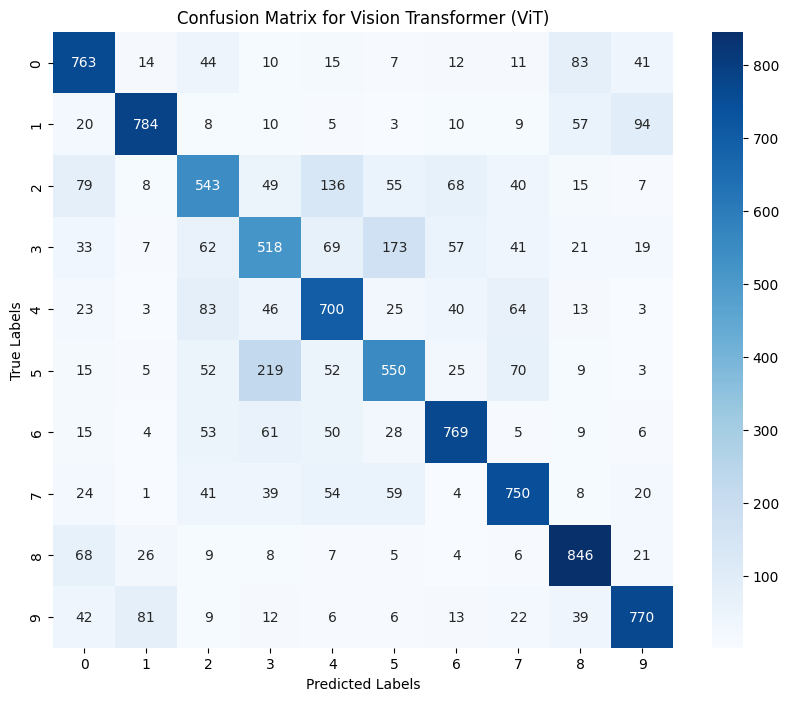

In [30]:
#Compute the confusion matrix
conf_matrix=confusion_matrix(y_test,y_pred_classes)

#Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=range(10),yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Vision Transformer (ViT)')
plt.show()

### CNN-MLP Model

In [31]:
class CNN_MLP(tf.keras.Model):
    def __init__(self,patch_size,num_patches,d_model,mlp_dim,num_classes):
        super(CNN_MLP,self).__init__()
        self.patches=create_patches
        self.conv_layer=tf.keras.layers.Conv2D(d_model,kernel_size=(3,3),activation='relu')
        self.flatten_patches=tf.keras.layers.Flatten()
        
        #MLP layers
        self.dense1=tf.keras.layers.Dense(mlp_dim,activation='relu')
        self.dense2=tf.keras.layers.Dense(num_classes)
    
    def call(self,x,training=False):
        #Divide the image into patches
        x=self.patches(x)
        x=tf.reshape(x,(-1,32,32,3))  
        
        #CNN feature extraction
        x=self.conv_layer(x)
        x=self.flatten_patches(x)
        
        #MLP layers
        x=self.dense1(x)
        x=self.dense2(x)
        return x


### Train the CNN-MLP Model

In [32]:
#Define hyperparameters for the hybrid model
mlp_dim=128
d_model=64
num_classes=10

#Initialize model
cnn_mlp_model=CNN_MLP(patch_size,num_patches,d_model,mlp_dim,num_classes)
cnn_mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#Train the model
history_cnn=cnn_mlp_model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=25,
    batch_size=batch_size,
    callbacks=[early_stopping,lr_scheduler]
)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4255 - loss: 1.6856 - val_accuracy: 0.5549 - val_loss: 1.2825 - learning_rate: 0.0010
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5911 - loss: 1.1601 - val_accuracy: 0.5780 - val_loss: 1.2110 - learning_rate: 9.5000e-04
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6618 - loss: 0.9573 - val_accuracy: 0.5846 - val_loss: 1.2121 - learning_rate: 9.0250e-04
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7221 - loss: 0.7905 - val_accuracy: 0.5839 - val_loss: 1.2361 - learning_rate: 8.5737e-04
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7759 - loss: 0.6392 - val_accuracy: 0.5794 - val_loss: 1.3365 - learning_rate: 8.1451e-04
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8270 - loss: 0.4967 - val_accuracy: 0.5856 - val_loss: 1.4229 - learning_rate: 7.7378e-04
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - 

### Evaluation

In [33]:
#Predict on the test set
y_pred_cnn_mlp=cnn_mlp_model.predict(x_test)
y_pred_cnn_mlp_classes=np.argmax(y_pred_cnn_mlp,axis=1)

#Calculate metrics
accuracy_cnn_mlp=accuracy_score(y_test,y_pred_cnn_mlp_classes)
precision_cnn_mlp=precision_score(y_test,y_pred_cnn_mlp_classes,average='weighted')
recall_cnn_mlp=recall_score(y_test,y_pred_cnn_mlp_classes,average='weighted')
f1_cnn_mlp=f1_score(y_test,y_pred_cnn_mlp_classes,average='weighted')

print(f"CNN-MLP Model Accuracy: {accuracy_cnn_mlp}")
print(f"CNN-MLP Model Precision: {precision_cnn_mlp}")
print(f"CNN-MLP Model Recall: {recall_cnn_mlp}")
print(f"CNN-MLP Model F1 Score: {f1_cnn_mlp}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN-MLP Model Accuracy: 0.5549
CNN-MLP Model Precision: 0.5607747452324899
CNN-MLP Model Recall: 0.5549
CNN-MLP Model F1 Score: 0.5522822654798218


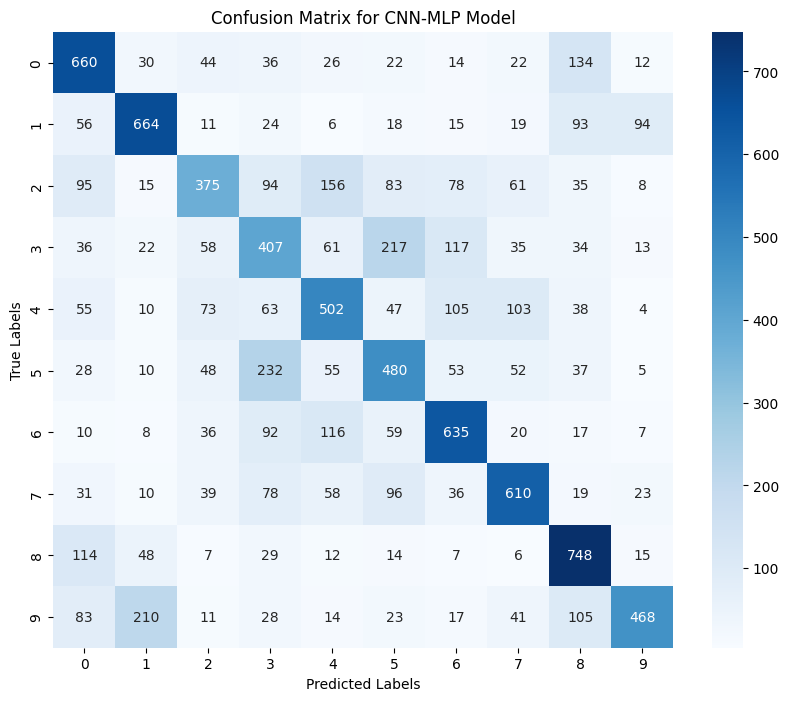

In [34]:
#Compute confusion matrix for CNN-MLP model
conf_matrix_cnn_mlp=confusion_matrix(y_test,y_pred_cnn_mlp_classes)

#Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_cnn_mlp,annot=True,fmt="d",cmap="Blues",xticklabels=range(10),yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CNN-MLP Model')
plt.show()


### Resnet Model

In [35]:
#Load the pretrained ResNet model
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(32,32,3)
)

#Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable=False

#Add custom classification head
x=Flatten()(base_model.output)
x=Dense(128,activation='relu')(x)
output_layer=Dense(10,activation='softmax')(x)

#Define the model
resnet_model=Model(inputs=base_model.input,outputs=output_layer)

#Compile the model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### Train the Model

In [36]:
#Train the model
history_resnet=resnet_model.fit(
    x_train,y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_test,y_test),
    callbacks=[early_stopping,lr_scheduler]
)


Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.2806 - loss: 1.9898 - val_accuracy: 0.3380 - val_loss: 1.8713 - learning_rate: 0.0010
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3717 - loss: 1.7492 - val_accuracy: 0.4038 - val_loss: 1.6776 - learning_rate: 9.5000e-04
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4020 - loss: 1.6753 - val_accuracy: 0.4120 - val_loss: 1.6472 - learning_rate: 9.0250e-04
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4099 - loss: 1.6414 - val_accuracy: 0.4255 - val_loss: 1.6105 - learning_rate: 8.5737e-04
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4246 - loss: 1.6124 - val_accuracy: 0.4308 - val_loss: 1.6179 - learning_rate: 8.1451e-04
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4320 - loss: 1.6027 - val_accuracy: 0.4180 - val_loss: 1.6119 - learning_rate: 7.7378e-04
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 1

### Compare all Models

In [39]:
#Measure inference time
def measure_inference_time(model,x_test):
    start_time=time.time()
    _=model.predict(x_test)
    end_time=time.time()
    return end_time-start_time

#Measure VIT performance
vit_inference_time=measure_inference_time(model,x_test)

#Print evaluation results
vit_accuracy=model.evaluate(x_test,y_test,verbose=0)[1]
print(f"VIT Model Accuracy: {accuracy}")
print(f"VIT Inference Time: {vit_inference_time} seconds")

#Measure CNN-MLP performance
cnn_mlp_inference_time=measure_inference_time(cnn_mlp_model,x_test)
cnn_mlp_accuracy=cnn_mlp_model.evaluate(x_test,y_test,verbose=0)[1]
print(f"CNN-MLP Model Accuracy: {accuracy_cnn_mlp}")
print(f"CNN-MLP Inference Time: {cnn_mlp_inference_time} seconds")


#Measure ResNet performance
resnet_inference_time=measure_inference_time(resnet_model,x_test)
resnet_accuracy=resnet_model.evaluate(x_test,y_test,verbose=0)[1]
print(f"ResNet Model Accuracy: {resnet_accuracy}")
print(f"ResNet Inference Time: {resnet_inference_time} seconds")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
VIT Model Accuracy: 0.6993
VIT Inference Time: 1.16865873336792 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN-MLP Model Accuracy: 0.5549
CNN-MLP Inference Time: 1.00565767288208 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
ResNet Model Accuracy: 0.33799999952316284
ResNet Inference Time: 8.327507734298706 seconds


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


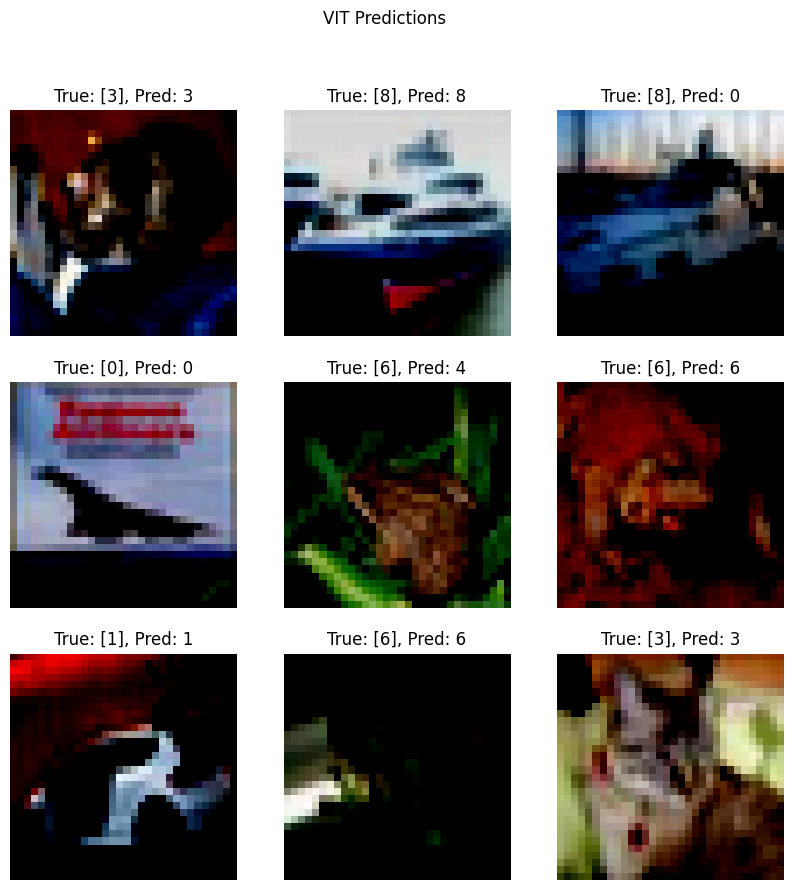

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


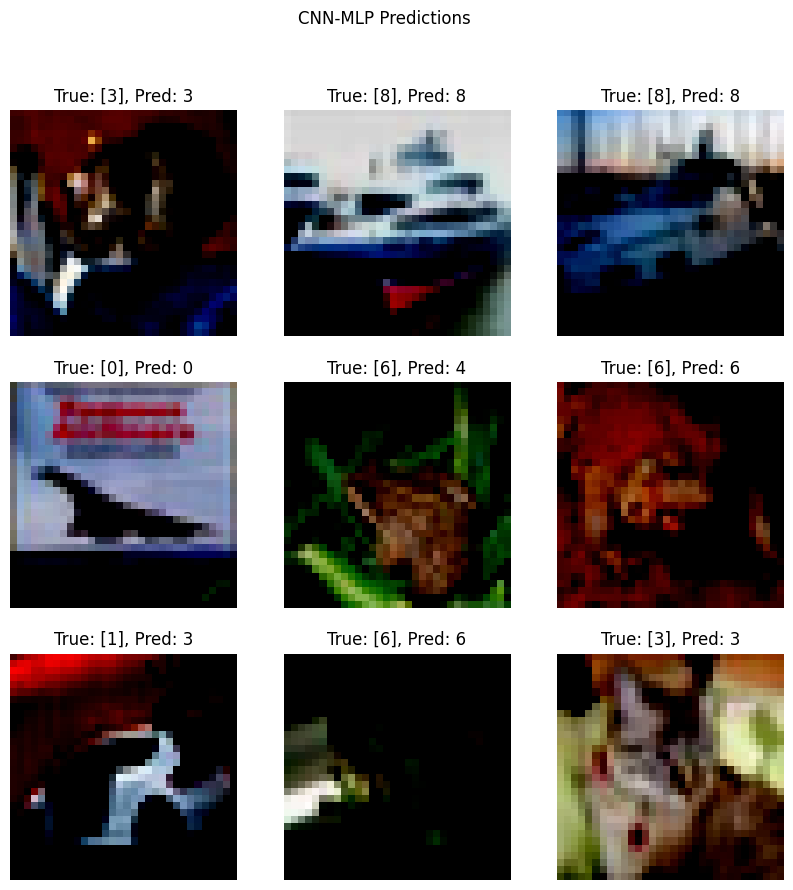

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


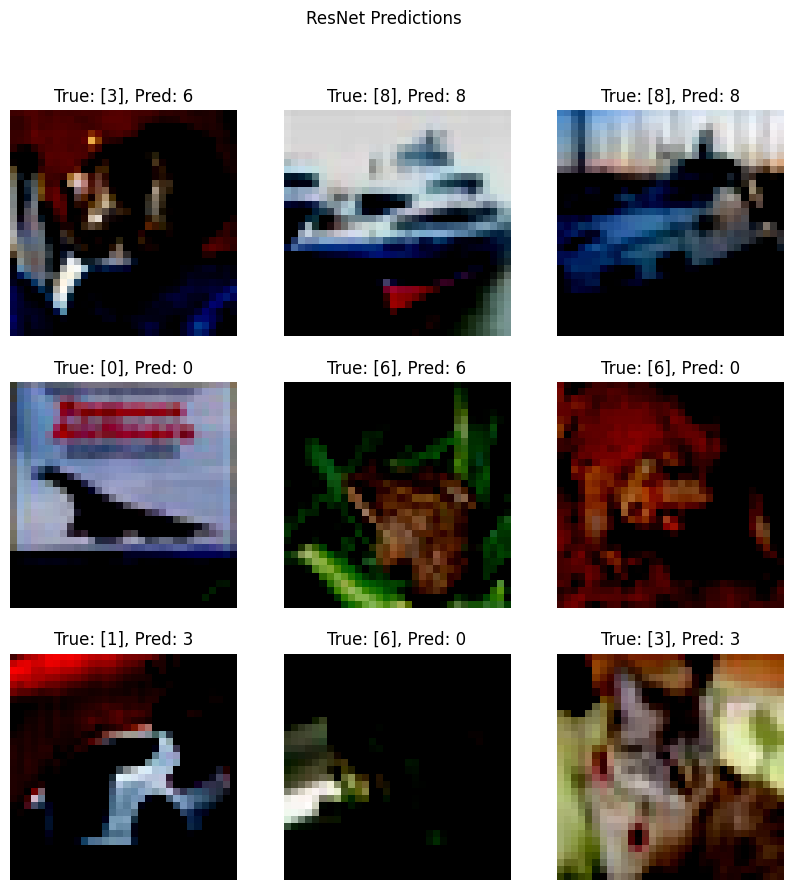

In [40]:
def visualize_predictions(model,x_test,y_test,title):
    y_pred=model.predict(x_test)
    y_pred_classes=np.argmax(y_pred,axis=1)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(x_test[i])
        plt.title(f"True: {y_test[i]}, Pred: {y_pred_classes[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

#Visualize ResNet predictions
visualize_predictions(model,x_test,y_test,title="VIT Predictions")
visualize_predictions(cnn_mlp_model,x_test,y_test,title="CNN-MLP Predictions")
visualize_predictions(resnet_model,x_test,y_test,title="ResNet Predictions")


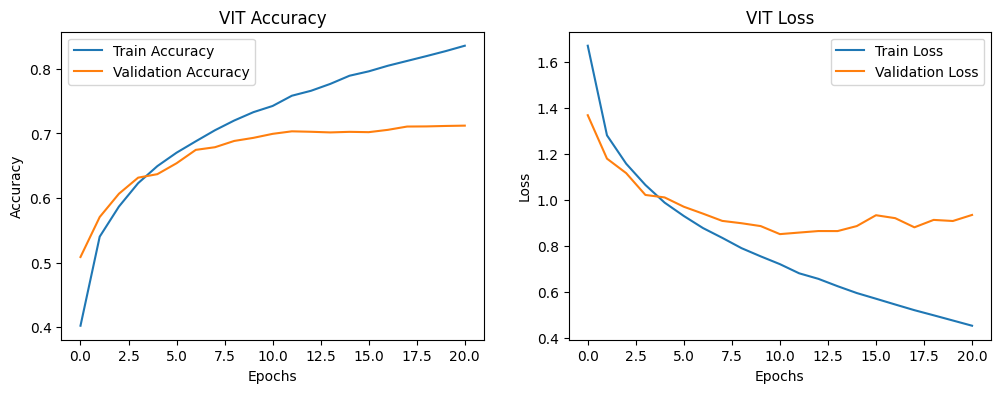

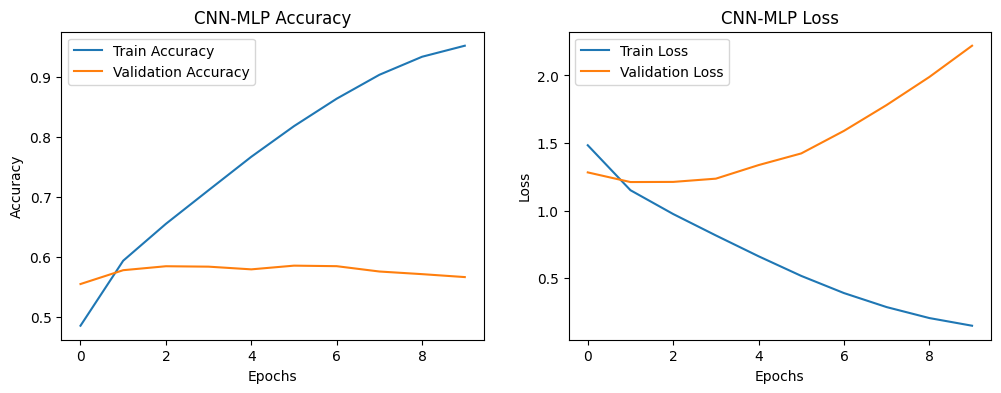

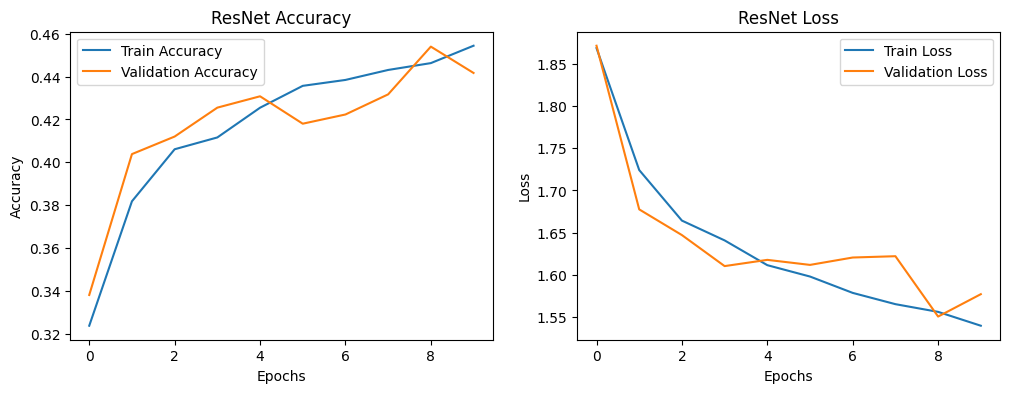

In [41]:
def plot_training_curves(history,model_name):
    plt.figure(figsize=(12,4))
    #Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],label='Train Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'],label='Train Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot for ResNet
plot_training_curves(history,'VIT')
plot_training_curves(history_cnn,'CNN-MLP')
plot_training_curves(history_resnet,'ResNet')
